# PyTorch qGAN Implementation


## Overview

This tutorial introduces step-by-step how to build a PyTorch-based Quantum Generative Adversarial Network algorithm.

The tutorial is structured as follows:

1. [Introduction](#1.-Introduction)
2. [Data and Represtation](#2.-Data-and-Representation)
3. [Definitions of the Neural Networks](#3.-Definitions-of-the-Neural-Networks)
4. [Setting up Parameters for the Training Loop](#4.-Setting-up-the-Training-Loop)
5. [Model Training](#5.-Model-Training)
6. [Results: Cumulative Density Functions](#6.-Results:-Cumulative-Density-Functions)
7. [Conclusion](#7.-Conclusion)

## 1. Introduction

The qGAN \[1\] is a hybrid quantum-classical algorithm used for generative modeling tasks. The algorithm uses the interplay of a quantum generator $G_{\theta}$, i.e., an ansatz (parametrized quantum circuit), and a classical discriminator $D_{\phi}$, a neural network, to learn the underlying probability distribution given training data.

The generator and discriminator are trained in alternating optimization steps, where the generator aims at generating probabilities that will be classified by the discriminator as training data values (i.e, probabilities from the real training distribution), and the discriminator tries to differentiate between original distribution and probabilities from the generator (in other words, telling apart the real and generated distributions). The final goal is for the quantum generator to learn a representation for the target probability distribution.
The trained quantum generator can, thus, be used to load a quantum state which is an approximate model of the target distribution.

**References:**

\[1\] Zoufal et al., [Quantum Generative Adversarial Networks for learning and loading random distributions](https://www.nature.com/articles/s41534-019-0223-2)

### 1.1. qGANs for Loading Random Distributions

Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn a random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$.

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to [Quantum Generative Adversarial Networks for Learning and Loading Random Distributions](https://arxiv.org/abs/1904.00043) _Zoufal, Lucchi, Woerner_ \[2019\].

For an example of how to use a trained qGAN in an application, the pricing of financial derivatives, please see the
[Option Pricing with qGANs](https://qiskit.org/ecosystem/finance/tutorials/10_qgan_option_pricing.html) tutorial.

## 2. Data and Representation

First, we need to load our training data $X$.

In this tutorial, the training data is given by a 2D multivariate normal distribution.

The goal of the generator is to learn how to represent such distribution, and the trained generator should correspond to an $n$-qubit quantum state
\begin{equation}
|g_{\text{trained}}\rangle=\sum\limits_{j=0}^{k-1}\sqrt{p_{j}}|x_{j}\rangle,
\end{equation}
where the basis states $|x_{j}\rangle$ represent the data items in the training data set
$X={x_0, \ldots, x_{k-1}}$ with $k\leq 2^n$ and $p_j$ refers to the sampling probability
of $|x_{j}\rangle$.

To facilitate this representation, we need to map the samples from the multivariate
normal distribution to discrete values. The number of values that can be represented
depends on the number of qubits used for the mapping.
Hence, the data resolution is defined by the number of qubits.
If we use $3$ qubits to represent one feature, we have $2^3 = 8$ discrete values.

We first begin by fixing seeds in the random number generators for reproducibility of the outcome in this tutorial.

In [19]:
import torch
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123456
_ = torch.manual_seed(123456)  # suppress output

We fix the number of dimensions, the discretization number and compute the number of qubits required as $2^3 = 8$.

In [20]:
import numpy as np

num_dim = 2
num_discrete_values = 8
num_qubits = num_dim * int(np.log2(num_discrete_values))

Then, we prepare a discrete distribution from the continuous 2D normal distribution. We evaluate the continuous probability density function (PDF) on the grid $(-2, 2)^2$ with a discretization of $8$ values per feature. Thus, we have $64$ values of the PDF. Since this will be a discrete distribution we normalize the obtained probabilities.

In [21]:
from scipy.stats import multivariate_normal

coords = np.linspace(-2, 2, num_discrete_values)
rv = multivariate_normal(mean=[0.0, 0.0], cov=[[1, 0], [0, 1]], seed=algorithm_globals.random_seed)
grid_elements = np.transpose([np.tile(coords, len(coords)), np.repeat(coords, len(coords))])
prob_data = rv.pdf(grid_elements)
prob_data = prob_data / np.sum(prob_data)

Let's visualize our distribution. It is a nice bell-shaped bivariate normal distribution on a discrete grid.

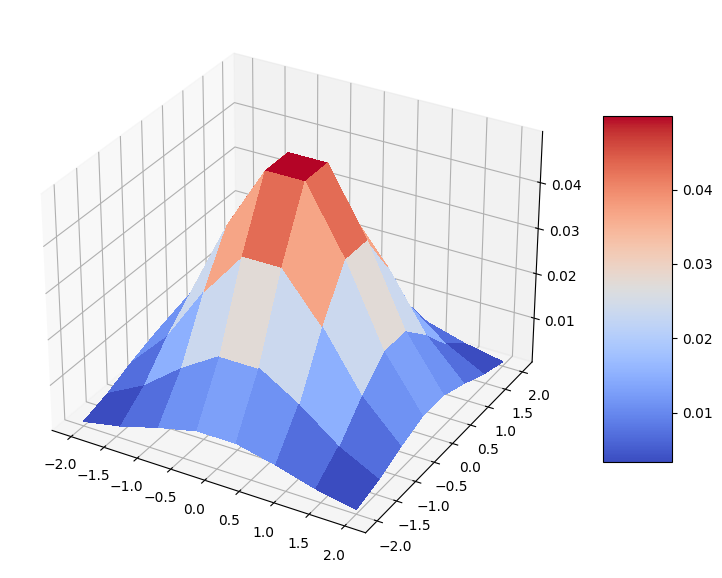

In [22]:
import matplotlib.pyplot as plt
from matplotlib import cm

mesh_x, mesh_y = np.meshgrid(coords, coords)
grid_shape = (num_discrete_values, num_discrete_values)

fig, ax = plt.subplots(figsize=(9, 9), subplot_kw={"projection": "3d"})
prob_grid = np.reshape(prob_data, grid_shape)
surf = ax.plot_surface(mesh_x, mesh_y, prob_grid, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

## 3. Definitions of the Neural Networks
In this section we define two neural networks as described above:

- A quantum generator as a quantum neural network.
- A classical discriminator as a PyTorch-based neural network.

### 3.1. Definition of the quantum neural network ansatz

Now, we define the parameterized quantum circuit $G\left(\boldsymbol{\theta}\right)$ with $\boldsymbol{\theta} = {\theta_1, ..., \theta_k}$ which will be used in our quantum generator.

To implement the quantum generator, we choose a hardware efficient ansatz with $6$ repetitions. The ansatz implements $R_Y$, $R_Z$ rotations and $CX$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be more than $1$ because higher circuit depths enable the representation of more complex structures. Here, we construct quite a deep circuit with a large number of parameters to be able to adequately capture and represent the distribution.

In [23]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import EfficientSU2, TwoLocal, PauliTwoDesign

qc = QuantumCircuit(num_qubits)
qc.h(qc.qubits)

ansatz = EfficientSU2(num_qubits, reps=6)
qc.compose(ansatz, inplace=True)

Let's draw our circuit and see what it looks like. On the plot we may notice a pattern that appears $6$ times.

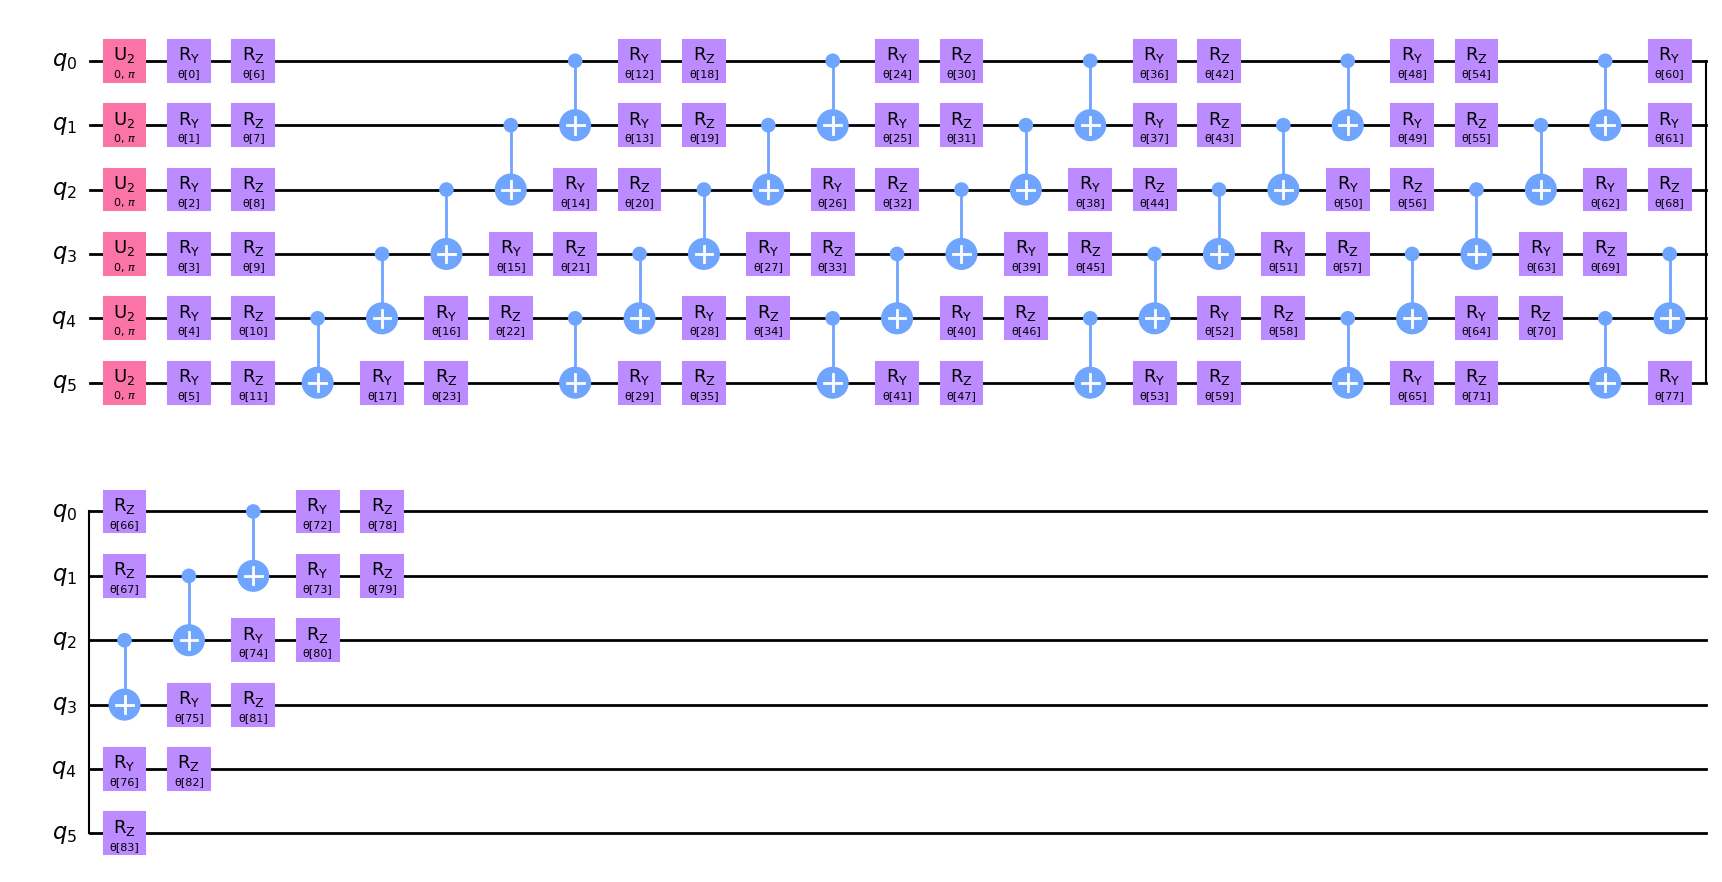

In [24]:
qc.decompose().draw("mpl")

Let's print the number of trainable parameters.

In [25]:
qc.num_parameters

84

### 3.2. Definition of the quantum generator

We start defining the generator by creating a sampler for the ansatz. The reference implementation is a statevector-based implementation, thus it returns exact probabilities as a result of circuit execution. We add the `shots` parameter to add some noise to the results. In this case the implementation samples probabilities from the multinomial distribution constructed from the measured quasi probabilities. And as usual we fix the seed for reproducibility purposes.

In [26]:
from qiskit.primitives import Sampler

shots = 10000
sampler = Sampler(options={"shots": shots, "seed": algorithm_globals.random_seed})

Next, we define a function that creates the quantum generator from a given parameterized quantum circuit. Inside this function we create a neural network that returns the quasi probability distribution evaluated by the underlying Sampler. We fix `initial_weights` for reproducibility purposes. In the end we wrap the created quantum neural network in `TorchConnector` to make use of PyTorch-based training.

In [27]:
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import SamplerQNN


def create_generator() -> TorchConnector:
    qnn = SamplerQNN(
        circuit=qc,
        sampler=sampler,
        input_params=[],
        weight_params=qc.parameters,
        sparse=False,
    )

    initial_weights = algorithm_globals.random.random(qc.num_parameters)
    return TorchConnector(qnn, initial_weights)

### 3.3. Definition of the classical discriminator

Next, we define a PyTorch-based classical neural network that represents the classical discriminator. The underlying gradients can be automatically computed with PyTorch.

In [28]:
from torch import nn


class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

### 3.4. Create a generator and a discriminator

Now we create a generator and a discriminator.

In [29]:
generator = create_generator()
discriminator = Discriminator(num_dim)

## 4. Setting up the Training Loop
In this section we set up:

- A loss function for the generator and discriminator.
- Optimizers for both.
- A utility plotting function to visualize training process.

### 4.1. Definition of the loss functions
We want to train the generator and the discriminator with binary cross entropy as the loss function:
$$L\left(\boldsymbol{\theta}\right)=\sum_jp_j\left(\boldsymbol{\theta}\right)\left[y_j\log(x_j) + (1-y_j)\log(1-x_j)\right],$$
where $x_j$ refers to a data sample and $y_j$ to the corresponding label.

Since PyTorch's `binary_cross_entropy` is not differentiable with respect to weights, we implement the loss function manually to be able to evaluate gradients.

In [30]:
def adversarial_loss(input, target, w):
    bce_loss = target * torch.log(input) + (1 - target) * torch.log(1 - input)
    weighted_loss = w * bce_loss
    total_loss = -torch.sum(weighted_loss)
    return total_loss

### 4.2. Definition of the optimizers
In order to train the generator and discriminator, we need to define optimization schemes. In the following, we employ a momentum based optimizer called Adam, see [Kingma et al., Adam: A method for stochastic optimization](https://arxiv.org/abs/1412.6980) for more details.

In [31]:
from torch.optim import Adam

lr = 0.008  # learning rate
b1 = 0.7  # first momentum parameter
b2 = 0.999  # second momentum parameter

generator_optimizer = Adam(generator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005)
discriminator_optimizer = Adam(
    discriminator.parameters(), lr=lr, betas=(b1, b2), weight_decay=0.005
)

### 4.3. Visualization of the training process
We will visualize what is happening during the training by plotting the evolution of the generator's and the discriminator's loss functions during the training, as well as the progress in the relative entropy between the trained and the target distribution. We define a function that plots the loss functions and relative entropy. We call this function once an epoch of training is complete.

Visualization of the training process begins when training data is collected across two epochs.

In [32]:
from IPython.display import clear_output


def plot_training_progress():
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

## 5. Model Training
In the training loop we monitor not only loss functions, but relative entropy as well. The relative entropy describes a distance metric for distributions. Hence, we can use it to benchmark how close/far away the trained distribution is from the target distribution.

Now, we are ready to train our model. It may take some time to train the model so be patient.

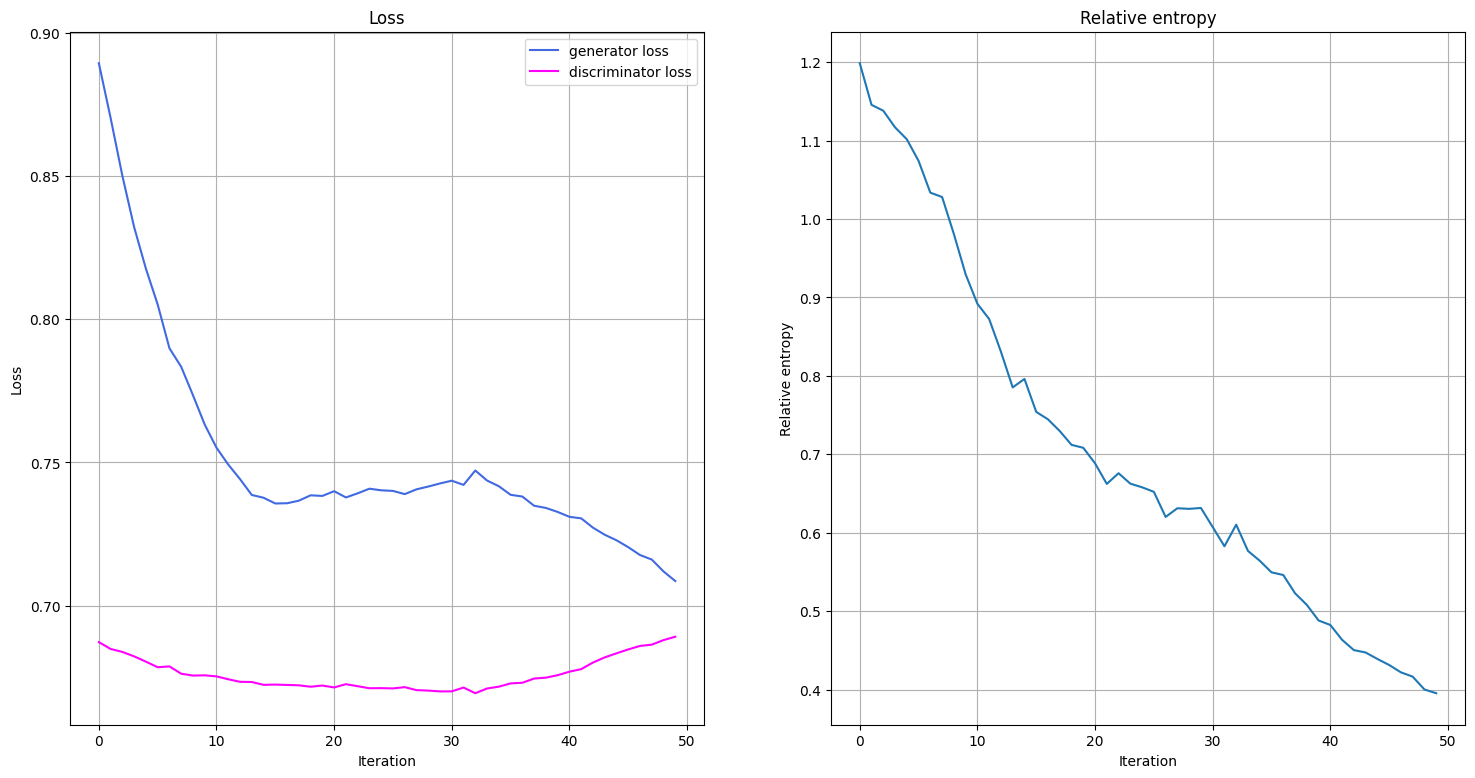

Fit in 229.96 sec


In [33]:
import time
from scipy.stats import multivariate_normal, entropy

n_epochs = 50

num_qnn_outputs = num_discrete_values**num_dim

generator_loss_values = []
discriminator_loss_values = []
entropy_values = []

start = time.time()
for epoch in range(n_epochs):

    valid = torch.ones(num_qnn_outputs, 1, dtype=torch.float)
    fake = torch.zeros(num_qnn_outputs, 1, dtype=torch.float)

    # Configure input
    real_dist = torch.tensor(prob_data, dtype=torch.float).reshape(-1, 1)

    # Configure samples
    samples = torch.tensor(grid_elements, dtype=torch.float)
    disc_value = discriminator(samples)

    # Generate data
    gen_dist = generator(torch.tensor([])).reshape(-1, 1)

    # Train generator
    generator_optimizer.zero_grad()
    generator_loss = adversarial_loss(disc_value, valid, gen_dist)

    # store for plotting
    generator_loss_values.append(generator_loss.detach().item())

    generator_loss.backward(retain_graph=True)
    generator_optimizer.step()

    # Train Discriminator
    discriminator_optimizer.zero_grad()

    real_loss = adversarial_loss(disc_value, valid, real_dist)
    fake_loss = adversarial_loss(disc_value, fake, gen_dist.detach())
    discriminator_loss = (real_loss + fake_loss) / 2

    # Store for plotting
    discriminator_loss_values.append(discriminator_loss.detach().item())

    discriminator_loss.backward()
    discriminator_optimizer.step()

    entropy_value = entropy(gen_dist.detach().squeeze().numpy(), prob_data)
    entropy_values.append(entropy_value)

    plot_training_progress()

elapsed = time.time() - start
print(f"Fit in {elapsed:0.2f} sec")

## 6. Results: Cumulative Density Functions
In this section we compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

First, we generate a new probability distribution with PyTorch autograd turned off as we are not going to train the model anymore.

In [34]:
with torch.no_grad():
    generated_probabilities = generator().numpy()

And then, we plot the cumulative distribution functions of the generated distribution, original distribution, and the difference between them. Please, be careful, the scale on the third plot **is not the same** as on the first and second plot, and the actual difference between the two plotted CDFs is pretty small.

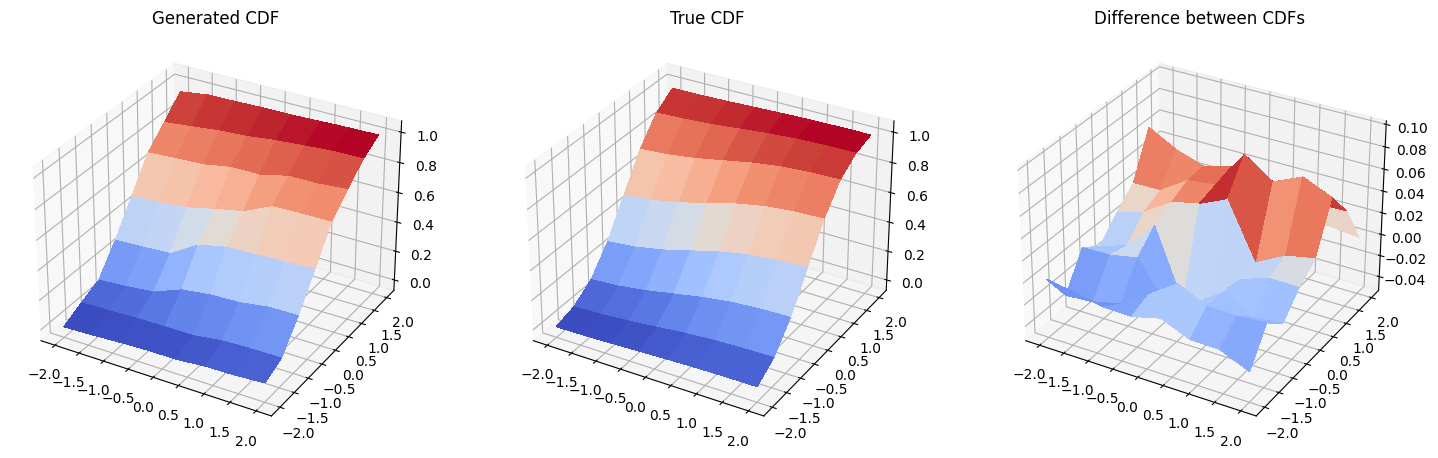

In [35]:
fig = plt.figure(figsize=(18, 9))

# Generated CDF
gen_prob_grid = np.reshape(np.cumsum(generated_probabilities), grid_shape)

ax1 = fig.add_subplot(1, 3, 1, projection="3d")
ax1.set_title("Generated CDF")
ax1.plot_surface(mesh_x, mesh_y, gen_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax1.set_zlim(-0.05, 1.05)

# Real CDF
real_prob_grid = np.reshape(np.cumsum(prob_data), grid_shape)

ax2 = fig.add_subplot(1, 3, 2, projection="3d")
ax2.set_title("True CDF")
ax2.plot_surface(mesh_x, mesh_y, real_prob_grid, linewidth=0, antialiased=False, cmap=cm.coolwarm)
ax2.set_zlim(-0.05, 1.05)

# Difference
ax3 = fig.add_subplot(1, 3, 3, projection="3d")
ax3.set_title("Difference between CDFs")
ax3.plot_surface(
    mesh_x, mesh_y, real_prob_grid - gen_prob_grid, linewidth=2, antialiased=False, cmap=cm.coolwarm
)
ax3.set_zlim(-0.05, 0.1)
plt.show()


## 7. Conclusion

Quantum generative adversarial networks employ the interplay of a generator and discriminator to map an approximate representation of a probability distribution underlying given data samples into a quantum channel. This tutorial presents a self-standing PyTorch-based qGAN implementation where the generator is given by a quantum channel, i.e., a variational quantum circuit, and the discriminator by a classical neural network, and discusses the application of efficient learning and loading of generic probability distributions into quantum states. The loading requires $\mathscr{O}\left(poly\left(n\right)\right)$ gates and can thus enable the use of potentially advantageous quantum algorithms.

In [36]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright